## Photo-z Validation

path: /data/des61.a/data/johnny/emulatorPhotoZ/training_sample/

In [1]:
import numpy as np
import os

from astropy.table import Table
from astropy.io.fits import getdata
a
import matplotlib.pyplot as plt

In [2]:
path = '/data/des61.a/data/johnny/emulatorPhotoZ/training_sample/'
path2= '/data/des61.a/data/johnny/DESY3/data/photoz/dnf_gold2/'

In [3]:
!ls /data/des61.a/data/johnny/emulatorPhotoZ/training_sample/

GSCHWEND.SPECZ_Y3_GOLD_2_2_27JUN19.pdf
match2.csv
match.csv
query.sql
readme.txt
spec_y3_gold_2_2_27JUN19.fits
spec_y3_gold_2_2_27JUN19_photoz2.fits
spec_y3_gold_2_2_27JUN19_photoz.fits
y3a2_spec_dered_small_nopointsources.fits
y3a2_specz_sample.html


In [4]:
infile = path+'spec_y3_gold_2_2_27JUN19_photoz.fits'

data = Table(getdata(infile))

In [5]:
data.columns

<TableColumns names=('COADD_OBJECT_ID','COADD_OBJECTS_ID','FLAGS_FOOTPRINT','FLAGS_BADREGIONS','FLAGS_FOREGROUND','FLAGS_GOLD','EXTENDED_CLASS_MASH_MOF','EXTENDED_CLASS_MOF','EXTENDED_CLASS_MASH_SOF','EXTENDED_CLASS_SOF','EXTENDED_CLASS_WAVG','EXTENDED_CLASS_COADD','FLAGS_I','FLAGS_G','FLAGS_R','FLAGS_Z','FLAGS_Y','MAGERR_AUTO_G','MAGERR_AUTO_R','MAGERR_AUTO_I','MAGERR_AUTO_Z','MAGERR_AUTO_Y','FLUX_AUTO_G','FLUX_AUTO_R','FLUX_AUTO_I','FLUX_AUTO_Z','FLUX_AUTO_Y','FLUXERR_AUTO_G','FLUXERR_AUTO_R','FLUXERR_AUTO_I','FLUXERR_AUTO_Z','FLUXERR_AUTO_Y','MOF_CM_MAG_CORRECTED_G','MOF_CM_MAG_CORRECTED_R','MOF_CM_MAG_CORRECTED_I','MOF_CM_MAG_CORRECTED_Z','MOF_CM_MAG_ERR_G','MOF_CM_MAG_ERR_R','MOF_CM_MAG_ERR_I','MOF_CM_MAG_ERR_Z','SOF_CM_MAG_CORRECTED_G','SOF_CM_MAG_CORRECTED_R','SOF_CM_MAG_CORRECTED_I','SOF_CM_MAG_CORRECTED_Z','SOF_CM_MAG_ERR_G','SOF_CM_MAG_ERR_R','SOF_CM_MAG_ERR_I','SOF_CM_MAG_ERR_Z','MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y','MATCH_OBJID','IDSPEC','RA','DEC

In [6]:
cols = ['Z','DNF_ZMEAN_MOF','DNF_ZSIGMA_MOF']

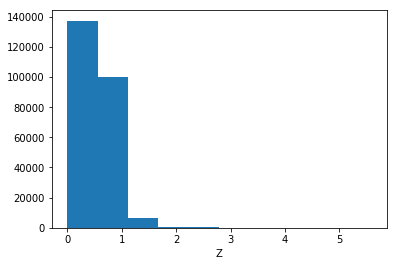

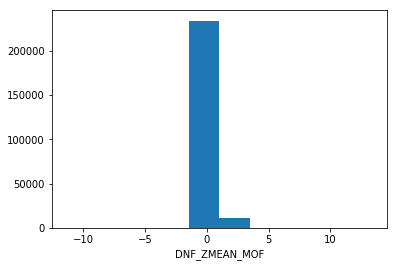

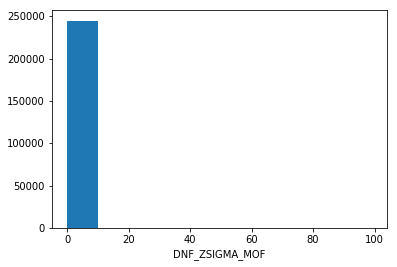

In [7]:
for col in cols:
    plt.figure()
    plt.hist(data[col])
    plt.xlabel(col)

# Assigning Variables
--------


In [8]:
ztrue = np.array(data['Z'])
zmean = np.array(data[cols[1]])
zsigm = np.array(data[cols[2]])

In [9]:
filters = ['G','R','I','Z']

mag_col_list = ['SOF_CM_MAG_CORRECTED_%s'%s for s in filters]
mag_list = np.vstack([np.array(data[col1]) for col1 in mag_col_list])

colors = np.vstack([np.array(data[col1]-data[col2]) for col1,col2 in zip(mag_col_list[:-1],mag_col_list[1:])])
colors

array([[1.70651758, 1.73046633, 1.69741221, ..., 1.86035189, 1.86693222,
        0.83090289],
       [0.82038225, 0.76487014, 0.5649704 , ..., 0.68572614, 0.67861891,
        0.37445003],
       [0.38919491, 0.33916583, 0.28888918, ..., 0.44276348, 0.35872511,
        0.30879369]])

In [10]:
mag_col_list

['SOF_CM_MAG_CORRECTED_G',
 'SOF_CM_MAG_CORRECTED_R',
 'SOF_CM_MAG_CORRECTED_I',
 'SOF_CM_MAG_CORRECTED_Z']

## Mask Data
-------------------

In [11]:
# Quality Flags

flags_gold = data['FLAGS_GOLD']
flags_foreground = data['FLAGS_FOREGROUND']
flags_badregions = data['FLAGS_BADREGIONS']
flags_footprint  = data['FLAGS_FOOTPRINT']

mask = flags_foreground == 0
mask&= flags_badregions < 2
mask&= flags_gold < 2
mask&= flags_footprint == 1

In [12]:
1.*np.count_nonzero(mask)/len(data)

1.0

In [13]:
# Redshift limit

z_cut = ztrue <= 0.65
1.*np.count_nonzero(z_cut)/len(data)

0.7002379064234734

In [14]:
# Color Mask

color_min, color_max = -1.,4.

for i in range(len(filters)-1):
    mask &= colors[i]<=color_max
    mask &= colors[i]>=color_min
    

In [15]:
1.*np.count_nonzero(mask)/len(data)

0.9984997997007775

In [16]:
# Mag Limit

mask &= mag_list[2]<=23.

In [17]:
1.*np.count_nonzero(mask)/len(data)

0.9539393543007104

# 0.2 L* Mag Cut
------------------

The charcteristic magnitude used in Buzzard is not directly provided. They have in DeRose+19 the luminosity functional form.

William Black fitted using 5 parameters, his fitted values for m(z) is in the cell bellow. It's important to mention that 0.2 / 0.4  corresponds to m(z)+1.75/1.00.

In [18]:
Z1 = [ 2.85703803, 23.35451485]
Z2 = [ -0.13290108,   1.11453393,  -3.74351207,   6.96351527, -10.04310863,  12.60755443,  -7.85820367,   0.92175766]
def char_luminosity(z):
    return np.poly1d(Z1)(np.log(z)) + np.poly1d(Z2)(z)

In [19]:
#print('applying mask')
mag_cut_z = mag_list[2] <= char_luminosity(ztrue)+1.75

In [20]:
1.*np.count_nonzero(mask&mag_cut_z)/len(data)

0.8955092096764963

In [21]:
final_mask = mask&mag_cut_z*z_cut

(0.0, 0.65)

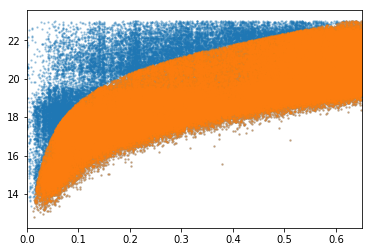

In [22]:
plt.scatter(ztrue[mask],mag_list[2][mask],s=2,alpha=0.3)
plt.scatter(ztrue[final_mask],mag_list[2][final_mask],s=2,alpha=0.3)
plt.xlim(0.,0.65)

# Modelling Photoz
------------

In [23]:
g = data[final_mask]

In [24]:
zt = np.array(g[cols[0]])
zp = np.array(g[cols[1]])
zerr = np.array(g[cols[2]])

In [25]:
deltaz = (zp-zt)/(1+zt)
deltaz_abs = np.abs(deltaz)

In [26]:
bias = np.median(deltaz)
print('bias: %.5f'%(bias))

bias: 0.00000


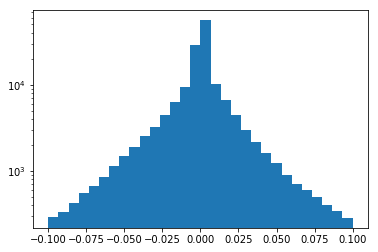

In [27]:
plt.hist(deltaz,bins=np.linspace(-0.1,0.1,31))
plt.yscale('log')

## DNF Precision
---------------

In [96]:
zvec = np.linspace(0.01,3,40)
xmin,xmax=-0.1,1.1
def identity(ztru,z,xmin=-0.05,xmax=2.,ax=None,alpha=0.01):
    if ax is None: ax=plt.axes()
    ax.plot(zvec,zvec,ls='--',color='k')
    ax.scatter(ztru,z,alpha=alpha,s=10,label='true members')
    ax.axhline(1.,color='k')
    ax.axvline(1.,color='k')
    ax.set_xlabel(r'$z_{true}$',fontsize=18)
    ax.set_ylabel(r'$z_{ph}$',fontsize=18)
    ax.set_ylim(xmin,xmax)
    ax.set_xlim(xmin,xmax)

In [97]:
z_max = 0.65

Text(0.5,1,'DNF Photoz - DES Gold_2_2')

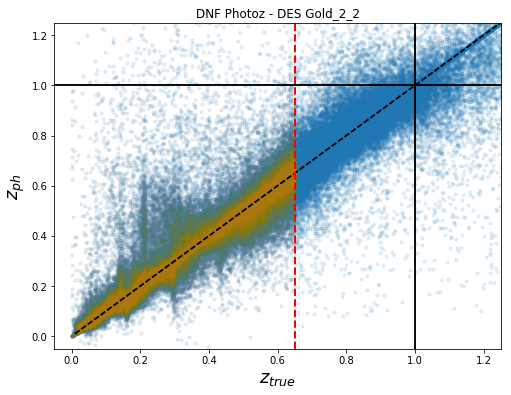

In [98]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
identity(ztrue,zmean,xmax=1.25,alpha=0.1,ax=ax)
identity(zt,zp,xmax=1.25,ax=ax)
ax.axvline(z_max,color='r',ls='--',lw=2)
plt.title('DNF Photoz - DES Gold_2_2')

## Photo-z Statistics
------------
Here we provide a summary of the photo-z accuracy in this sample.

In [226]:
def group_by(x,keys):
    return [x[idx] for idx in keys]
    
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    indices = []
    means = (xedges[1:]+xedges[:-1])/2.
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

def fractional_error_percentile(var):
    p16 = np.nanpercentile(var, 16)
    p84 = np.nanpercentile(var, 84)
    score = 0.5*(p84-p16)
    return score

def mad(data, axis=None):
    return np.median(np.abs(data - np.median(data)))

def get_sigmaNMAD(var):
    sigmaNMAD = 1.48*mad(var)
    return sigmaNMAD

def get_outlier_frac(var,std):
    bias      = np.nanmedian(var)
    out       = np.where(np.abs((var-bias)>=2.*std))[0]
    frac      = 1.*out.size/var.size
    return frac

def filter_nan_inf(x):
    mask = np.isinf(x)|np.isnan(x)
    x[mask] = -99.
    return x

### As a function of true redshift
----------

In [227]:
len(dz_bins_g)

23

In [228]:
dx = 0.025
zbins = np.arange(0.1-dx/2,.65+dx,dx)
keys,zb  = get_bins(zt,zbins)
dz_bins_g= group_by(deltaz,keys)
zerr_bins= group_by(zerr,keys)

scatter_b= np.array([fractional_error_percentile(db)    for db in dz_bins_g])
bias_b   = np.array([np.median(db)        for db in dz_bins_g])
of_b     = np.array([get_outlier_frac(db,si) for db,si in zip(dz_bins_g,scatter_b)]) 
zerr_b   = np.array([np.nanmedian(db)     for db in  zerr_bins])
keys,zb  = get_bins(zt,zbins)
dz_bins_g= group_by(deltaz,keys)


scatter_bt= np.array([get_sigmaNMAD(db)    for db in dz_bins_g])
bias_bt   = np.array([np.median(db)        for db in dz_bins_g])
of_bt     = np.array([get_outlier_frac(db,si) for db,si in zip(dz_bins_g,scatter_bt)]) 

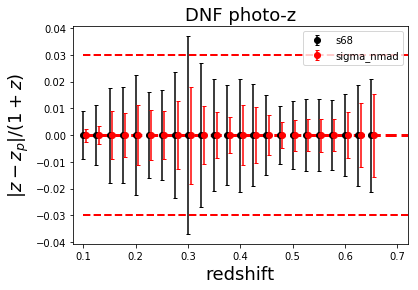

In [229]:
plt.errorbar(zb,bias_b,color='k',fmt='o',capsize=2,yerr=scatter_b,label='s68')
plt.errorbar(zb+0.005,bias_bt,color='r',fmt='o',capsize=2,yerr=scatter_bt,label='sigma_nmad')

plt.plot([0.1,1.],[0.,0.],'r--',lw=3)
plt.plot([0.1,1.],[-.03,-0.03],'r--',lw=2)
plt.plot([0.1,1.],[+.03,+0.03],'r--',lw=2)

plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('redshift',fontsize=18)
plt.title('DNF photo-z',fontsize=18)
plt.xlim(0.08,0.72)
plt.legend()

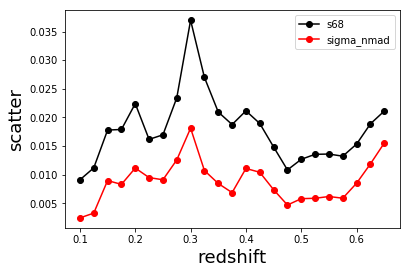

In [230]:
plt.plot(zb,scatter_b,'o-',color='k',label='s68')
plt.plot(zb,scatter_bt,'o-',color='r',label='sigma_nmad')
plt.ylabel('scatter',fontsize=18)
plt.xlabel('redshift',fontsize=18)
plt.legend()

Text(0.5,0,'redshift')

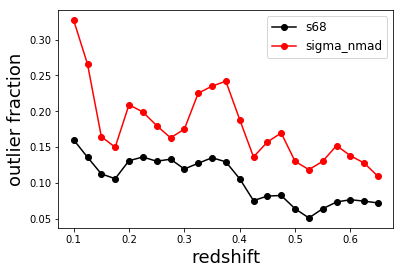

In [231]:
plt.plot(zb,of_b,'o-',color='k',label='s68')
plt.plot(zb,of_bt,'o-',color='r',label='sigma_nmad')
plt.ylabel('outlier fraction',fontsize=18)
plt.legend(fontsize=12)
plt.xlabel('redshift',fontsize=18)

Text(0.5,0,'redshift')

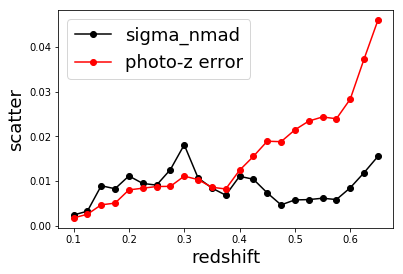

In [232]:
plt.plot(zb,scatter_bt,'o-',color='k',label='sigma_nmad')
plt.plot(zb,zerr_b,'o-',color='r',label='photo-z error')
plt.ylabel('scatter',fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('redshift',fontsize=18)


Text(0,0.5,'photoz_error/scatter')

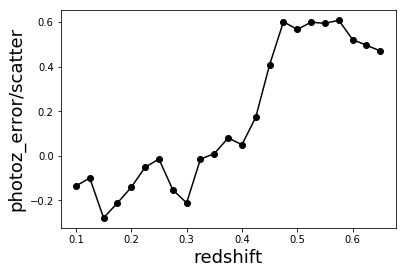

In [233]:
plt.plot(zb,np.log10(zerr_b/scatter_bt),'o-',color='k',label='sigma_nmad')
plt.xlabel('redshift',fontsize=18)
plt.ylabel('photoz_error/scatter',fontsize=18)

### As a function of magnitude
----------

In [234]:
g2    = data[mask&z_cut] 
magi  = np.array(g2['SOF_CM_MAG_CORRECTED_I'])

zt = np.array(g2[cols[0]])
zp = np.array(g2[cols[1]])
zerr = np.array(g2[cols[2]])

deltaz = (zp-zt)/(1+zt)
deltaz_abs = np.abs(deltaz)

In [235]:
zcut, = np.where(zt<=z_max)
mag_min = np.percentile(magi[zt<=0.11],0.1)
mag_max = np.percentile(magi[np.abs(zt-z_max)<=0.01],99.9)
print('magnitude limits')
print('min, max: %.2f, %.2f'%(mag_min,mag_max))

magnitude limits
min, max: 13.34, 22.96


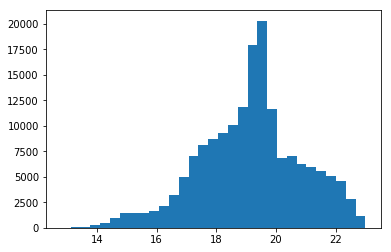

In [236]:
_ = plt.hist(magi,bins=31)

Text(0,0.5,'mag_i')

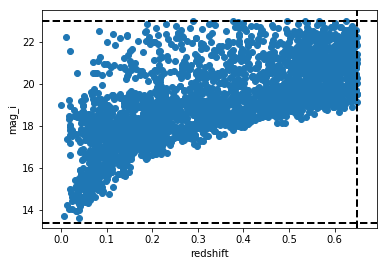

In [237]:
plt.scatter(zt[::50],magi[::50])
plt.axvline(z_max  , color='k', ls='--',lw=2)
plt.axhline(mag_min, color='k', ls='--',lw=2)
plt.axhline(mag_max, color='k', ls='--',lw=2)
plt.xlabel('redshift')
plt.ylabel('mag_i')

In [238]:
mbins = np.percentile(magi, np.linspace(0.,100.,25))

In [239]:
# mbins      = np.arange(mag_min-0.25/2, mag_max, 0.25)
m_keys,mb  = get_bins(magi,mbins)
m_dz_bins_g= group_by(deltaz,m_keys)
m_zerr_bins= group_by(zerr  ,m_keys)

m_scatter_b= np.array([fractional_error_percentile(db)    for db in m_dz_bins_g])
m_bias_b   = np.array([np.nanmedian(db)     for db in  m_dz_bins_g])
m_zerr_b   = np.array([[np.nanmedian(db),np.nanstd(db)]     for db in  m_zerr_bins])
m_of_b     = np.array([get_outlier_frac(db,si) for db,si in zip(m_dz_bins_g,m_scatter_b)]) 

m_dz_bins_gt= group_by(deltaz, m_keys)
m_scatter_bt= np.array([get_sigmaNMAD(db)    for db in m_dz_bins_gt])
m_bias_bt   = np.array([np.median(db)        for db in m_dz_bins_gt])
m_of_bt     = np.array([get_outlier_frac(db,si) for db,si in zip(m_dz_bins_gt,m_scatter_bt)]) 

Text(0.5,1,'all galaxies')

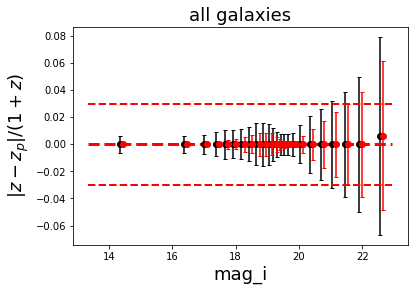

In [240]:
plt.errorbar(mb,m_bias_b,color='k',fmt='o',capsize=2,yerr=m_scatter_b)
plt.errorbar(mb+0.1,m_bias_bt,color='r',fmt='o',capsize=2,yerr=m_scatter_bt)
plt.plot([mag_min,mag_max],[0.,0.],'r--',lw=3)
plt.plot([mag_min,mag_max],[-.03,-0.03],'r--',lw=2)
plt.plot([mag_min,mag_max],[+.03,+0.03],'r--',lw=2)
plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('mag_i',fontsize=18)
plt.title('all galaxies',fontsize=18)

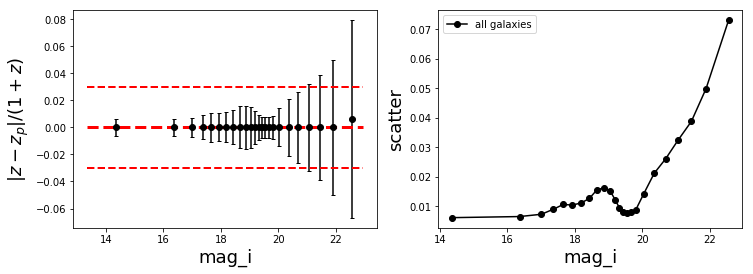

In [241]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.errorbar(mb,m_bias_b,color='k',fmt='o',capsize=2,yerr=m_scatter_b)
# plt.errorbar(mb+0.1,m_bias_bt,color='r',fmt='o',capsize=2,yerr=m_scatter_bt)
plt.plot([mag_min,mag_max],[0.,0.],'r--',lw=3)
plt.plot([mag_min,mag_max],[-.03,-0.03],'r--',lw=2)
plt.plot([mag_min,mag_max],[+.03,+0.03],'r--',lw=2)
plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('mag_i',fontsize=18)

fig.add_subplot(122)
plt.plot(mb,m_scatter_b,'o-',color='k',label='all galaxies')
# plt.plot(mb,m_scatter_bt,'o-',color='r',label='true members')
plt.ylabel('scatter',fontsize=18)
plt.xlabel('mag_i',fontsize=18)
plt.legend()

Text(0.5,0,'mag_i')

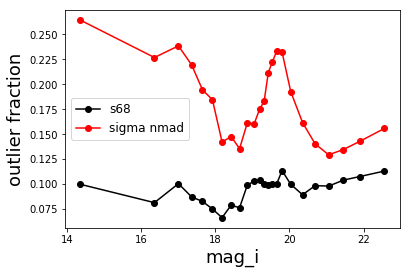

In [242]:
plt.plot(mb,m_of_b,'o-',color='k',label='s68')
plt.plot(mb,m_of_bt,'o-',color='r',label='sigma nmad')
plt.ylabel('outlier fraction',fontsize=18)
plt.legend(fontsize=12)
plt.xlabel('mag_i',fontsize=18)

(-0.01, 0.15)

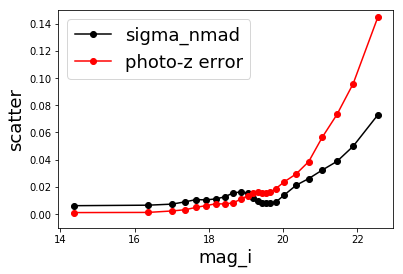

In [243]:
plt.plot(mb,m_scatter_b,'o-',color='k',label='sigma_nmad')
plt.plot(mb,m_zerr_b[:,0],'o-',color='r',label='photo-z error')

# plt.errorbar(mb,m_zerr_b[:,0],color='r',fmt='o',capsize=2,yerr=m_zerr_b[:,1])

plt.ylabel('scatter',fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('mag_i',fontsize=18)
plt.ylim(-0.01,0.15)

## Saving Output
------------

In [244]:
outfile = '../../analysis/aux_files/modelDNF_correction_z_gold_2_2.txt'

In [245]:
sigma = scatter_b
bias  = bias_b
of    = of_b

zlow = np.zeros_like(sigma)
zhigh = np.zeros_like(sigma)

In [246]:
## Saving the output
savefile = open(outfile, "w")
with open(outfile, "w") as savefile:
    header = '#z   ,bias  ,sigma ,zlow ,zhigh, outlierFrac  \n'
    savefile.write(header)
    for i in range(len(zb)):
        line = '%.3f,%.3f,%.3f,%.3f,%.3f,%.3f\n'%(zb[i],bias[i],sigma[i],zlow[i],zhigh[i],of[i])
        savefile.write(line)
savefile.close()

In [247]:
!cat ../../analysis/aux_files/modelDNF_correction_z_gold_2_2.txt

#z   ,bias  ,sigma ,zlow ,zhigh, outlierFrac  
0.100,0.000,0.009,0.000,0.000,0.160
0.125,0.000,0.011,0.000,0.000,0.136
0.150,0.000,0.018,0.000,0.000,0.113
0.175,0.000,0.018,0.000,0.000,0.106
0.200,0.000,0.022,0.000,0.000,0.131
0.225,0.000,0.016,0.000,0.000,0.136
0.250,0.000,0.017,0.000,0.000,0.130
0.275,0.000,0.023,0.000,0.000,0.133
0.300,0.000,0.037,0.000,0.000,0.119
0.325,0.000,0.027,0.000,0.000,0.127
0.350,0.000,0.021,0.000,0.000,0.135
0.375,0.000,0.019,0.000,0.000,0.129
0.400,0.000,0.021,0.000,0.000,0.106
0.425,0.000,0.019,0.000,0.000,0.075
0.450,0.000,0.015,0.000,0.000,0.082
0.475,0.000,0.011,0.000,0.000,0.082
0.500,0.000,0.013,0.000,0.000,0.064
0.525,-0.000,0.014,0.000,0.000,0.051
0.550,-0.000,0.014,0.000,0.000,0.064
0.575,0.000,0.013,0.000,0.000,0.073
0.600,0.000,0.015,0.000,0.000,0.077
0.625,0.000,0.019,0.000,0.000,0.075
0.650,0.000,0.021,0.000,0.000,0.072


# Check Photoz Sample

In [2]:
#infile = '/data/des61.a/data/johnny/DESY3/data/output/tiles/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_wv1.2_subsampled_copa_v2.1_00256.hdf5'
import h5py

path   = '/data/des81.b/data/mariaeli/y3_cats/subsampled/'
fname  = path+'Y3_GOLD_2_2.1_subsampled.h5'
master = h5py.File(fname,'r')


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def show_h5_group(name,node):
    ''' show all the h5 groups
    Example:
    fmaster = h5py.File(copa.master_fname,'r')
    fmaster.visititems(show_h5_group)

    ## https://stackoverflow.com/questions/45562169/traverse-hdf5-file-tree-and-continue-after-return
    '''
    if isinstance(node, h5py.Group):
        print(name,node)
    return None

def show_h5_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name,node)
    return None

In [6]:
master.visititems(show_h5_dataset)

(u'catalog/gold/a_sed_sfd98_g', <HDF5 dataset "a_sed_sfd98_g": shape (39926304,), type ">f4">)
(u'catalog/gold/a_sed_sfd98_i', <HDF5 dataset "a_sed_sfd98_i": shape (39926304,), type ">f4">)
(u'catalog/gold/a_sed_sfd98_r', <HDF5 dataset "a_sed_sfd98_r": shape (39926304,), type ">f4">)
(u'catalog/gold/a_sed_sfd98_z', <HDF5 dataset "a_sed_sfd98_z": shape (39926304,), type ">f4">)
(u'catalog/gold/coadd_object_id', <HDF5 dataset "coadd_object_id": shape (39926304,), type ">i8">)
(u'catalog/gold/dec', <HDF5 dataset "dec": shape (39926304,), type ">f8">)
(u'catalog/gold/delta_mag_chrom_g', <HDF5 dataset "delta_mag_chrom_g": shape (39926304,), type ">f4">)
(u'catalog/gold/delta_mag_chrom_i', <HDF5 dataset "delta_mag_chrom_i": shape (39926304,), type ">f4">)
(u'catalog/gold/delta_mag_chrom_r', <HDF5 dataset "delta_mag_chrom_r": shape (39926304,), type ">f4">)
(u'catalog/gold/delta_mag_chrom_z', <HDF5 dataset "delta_mag_chrom_z": shape (39926304,), type ">f4">)
(u'catalog/gold/delta_mag_y4_g', <